<a href="https://colab.research.google.com/github/PhanTung-06/Predict-Craft/blob/master/DINTUN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA PRE-PROCESSING


## Download data

In [2]:
%cd /content

/content


In [3]:
!mkdir DINTUN

In [4]:
%cd DINTUN

/content/DINTUN


In [5]:
!gdown --id 1Ne7LZ3b1mvYECV_tFTrxKcQF4yqf0-mF # train set
!gdown --id 1-E8X38I_h1NxacL6O6Defl6Zd_jbw3ph # test set

Downloading...
From: https://drive.google.com/uc?id=1Ne7LZ3b1mvYECV_tFTrxKcQF4yqf0-mF
To: /content/DINTUN/train.zip
542MB [00:06, 79.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-E8X38I_h1NxacL6O6Defl6Zd_jbw3ph
To: /content/DINTUN/public_test.zip
320MB [00:03, 94.0MB/s]


In [6]:
!unzip train.zip
!unzip public_test.zip

Archive:  train.zip
   creating: train/
   creating: train/images/
  inflating: train/images/train_0013.jpg  
  inflating: train/images/train_0345.jpg  
  inflating: train/images/train_0979.jpg  
  inflating: train/images/train_1205.jpg  
  inflating: train/images/train_0367.jpg  
  inflating: train/images/train_0533.jpg  
  inflating: train/images/train_0517.jpg  
  inflating: train/images/train_0948.jpg  
  inflating: train/images/train_0612.jpg  
  inflating: train/images/train_0408.jpg  
  inflating: train/images/train_0598.jpg  
  inflating: train/images/train_0127.jpg  
  inflating: train/images/train_0145.jpg  
  inflating: train/images/train_1185.jpg  
  inflating: train/images/train_0825.jpg  
  inflating: train/images/train_0426.jpg  
  inflating: train/images/train_0394.jpg  
  inflating: train/images/train_0208.jpg  
  inflating: train/images/train_0150.jpg  
  inflating: train/images/train_0229.jpg  
  inflating: train/images/train_0733.jpg  
  inflating: train/images/trai

## DATA ANALYST

In [30]:
import os
import cv2 
import glob
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.io import output_notebook, show, output_file

TEST_DIR = 'public_test/'
TRAIN_DIR = 'train/'

train_image_dir = os.path.join(TRAIN_DIR, 'images/')
train_txt_dir = os.path.join(TRAIN_DIR, 'labels/')

In [31]:
train_images_list = glob.glob(train_image_dir + '*')
test_images_list = glob.glob(TEST_DIR + '*')

print('number of train images: ', len(train_images_list))
print('number of public test images: ', len(test_images_list))

number of train images:  1240
number of public test images:  987


In [32]:
# ground-truth from txt to dataframe
def to_dataframe(image_dir, txt_dir):
    labels_list = []
    txt_list = glob.glob(txt_dir + '*')
    for number, txt in enumerate(txt_list):
        # print(number)
        file_name = os.path.basename(txt)
        image_id = file_name.split('.')[0]
        image_path = os.path.join(image_dir, image_id + '.jpg')
        im = Image.open(image_path)
        width, height = im.size
        f = open(txt, "r")
        lines = f.readlines()
        for line in lines:
            elements = line.split(',')
            if len(elements) != 9:
                raise RuntimeError('Wrong data format')
            else:
                text = elements[-1].rstrip('\n')
                bbox = [int(i) for i in elements[:-1]]
            labels_list.append([image_id, width, height, bbox, text])
    return pd.DataFrame(labels_list, columns=['image_id', 'width', 'height', 'bbox', 'text'])
                
raw_data = to_dataframe(train_image_dir, train_txt_dir)
raw_data

,image_id,width,height,bbox,text
0,train_0124,201,251,"[54, 0, 149, 0, 154, 47, 57, 50]",TLP
1,train_0124,201,251,"[112, 45, 146, 48, 146, 57, 116, 58]",Printing
2,train_0124,201,251,"[201, 251, 201, 251, 201, 251, 201, 251]",009
3,train_0124,201,251,"[63, 251, 96, 251, 95, 251, 62, 251]",1900
4,train_0124,201,251,"[56, 45, 102, 45, 102, 55, 57, 54]",Advertising
...,...,...,...,...,...
53972,train_0207,1008,756,"[705, 279, 744, 277, 741, 296, 707, 295]",CÁC
53973,train_0207,1008,756,"[628, 275, 655, 275, 654, 293, 628, 293]",CÁ
53974,train_0207,1008,756,"[348, 328, 379, 329, 379, 350, 344, 346]",ĐC:
53975,train_0207,1008,756,"[152, 418, 178, 410, 178, 423, 155, 428]",Tiger


In [33]:
print('number unique image in dataframe: ', raw_data['image_id'].nunique())
raw_data.info()

number unique image in dataframe:  1240
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53977 entries, 0 to 53976
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  53977 non-null  object
 1   width     53977 non-null  int64 
 2   height    53977 non-null  int64 
 3   bbox      53977 non-null  object
 4   text      53977 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.1+ MB


In [34]:
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.image_id == image_id]
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append(row.bbox)
    return bboxes

# plot bboxes on image
def plot_image_examples(df, rows=3, cols=3, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(15,15))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id
            
            img = Image.open(os.path.join(train_image_dir, img_id + '.jpg'))
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                poly = [(bbox[0], bbox[1]), (bbox[2], bbox[3]), (bbox[4], bbox[5]), (bbox[6], bbox[7])]
                rect = patches.Polygon(poly ,linewidth=1,edgecolor='r',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

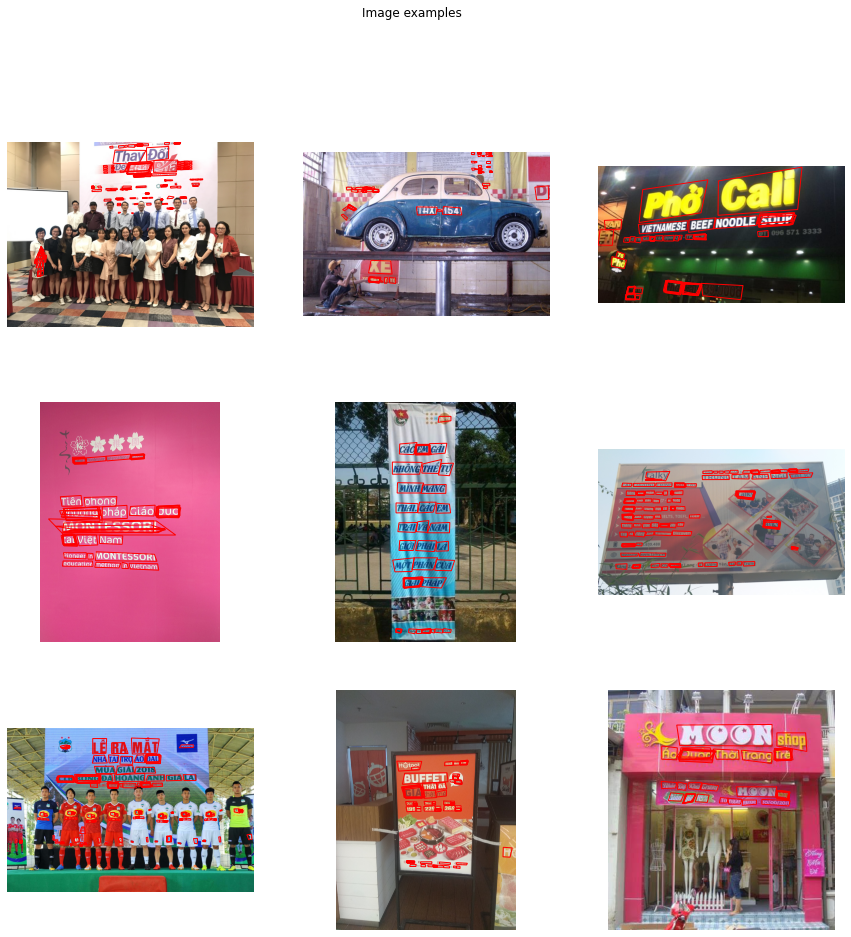

In [35]:
# plot 9 random images
plot_image_examples(raw_data)

In [36]:
def calculate_area(bbox):
    coords = ((bbox[0], bbox[1]), (bbox[2], bbox[3]), (bbox[4], bbox[5]), (bbox[6], bbox[7]))
    poly = Polygon(coords)
    return poly.area
raw_data['area'] = raw_data['bbox'].apply(lambda x: calculate_area(x))
raw_data

,image_id,width,height,bbox,text,area
0,train_0124,201,251,"[54, 0, 149, 0, 154, 47, 57, 50]",TLP,4662.0
1,train_0124,201,251,"[112, 45, 146, 48, 146, 57, 116, 58]",Printing,350.0
2,train_0124,201,251,"[201, 251, 201, 251, 201, 251, 201, 251]",009,0.0
3,train_0124,201,251,"[63, 251, 96, 251, 95, 251, 62, 251]",1900,0.0
4,train_0124,201,251,"[56, 45, 102, 45, 102, 55, 57, 54]",Advertising,432.0
...,...,...,...,...,...,...
53972,train_0207,1008,756,"[705, 279, 744, 277, 741, 296, 707, 295]",CÁC,638.5
53973,train_0207,1008,756,"[628, 275, 655, 275, 654, 293, 628, 293]",CÁ,477.0
53974,train_0207,1008,756,"[348, 328, 379, 329, 379, 350, 344, 346]",ĐC:,648.5
53975,train_0207,1008,756,"[152, 418, 178, 410, 178, 423, 155, 428]",Tiger,291.5


In [37]:
raw_data.describe()

,width,height,area
count,53977.000000,53977.000000,5.397700e+04
mean,1260.054820,1045.461511,7.019410e+03
std,1175.174669,1090.536432,4.564015e+04
min,168.000000,128.000000,0.000000e+00
25%,500.000000,332.000000,1.650000e+02
50%,800.000000,600.000000,7.805000e+02
75%,1600.000000,1332.000000,3.033000e+03
max,5184.000000,4608.000000,4.309383e+06


In [38]:
def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=100, title=''):
    hist, edges = np.histogram(dataframe[column], bins = bins)
    
    hist_df = pd.DataFrame({column: hist,
                             "left": edges[:-1],
                             "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]

    src = ColumnDataSource(hist_df)
    plot = figure(plot_height = 400, plot_width = 800,
          title = title,
          x_axis_label = column,
          y_axis_label = "Count")    
    plot.quad(bottom = 0, top = column,left = "left", 
        right = "right", source = src, fill_color = colors[0], 
        line_color = "#35838d", fill_alpha = 0.7,
        hover_fill_alpha = 0.7, hover_fill_color = colors[1])
        
    hover = HoverTool(tooltips = [('Interval', '@interval'),
                              ('Count', str("@" + column))])
    plot.add_tools(hover)
    
    output_notebook()
    show(plot)

In [39]:
hist_hover(raw_data, 'area', title='Area of bbox')

Data train có nhiều box bị trùng nhau trên cùng 1 text và số lượng bbox small rất nhiều. Ở đây chúng tôi chưa có nhiều thơi gian để thực hiện thử nghiệm và processing đối với phần area của các box mà chỉ đi vào loại bỏ các box bị overlap với nhau và chọn ra box hợp lý nhất từ các toạ độ bbox đó. Ngoài ra có khoảng 250 - 300 ảnh ko chưa text cũng sẽ được loại bỏ dựa trên shape của image và toạ độ các box đối vơi những ảnh này.

## Pre-Processing

### CHỌN VÀ TẠO BOX MỚI CHO TEXT. BỎ NHỮNG BOX DƯ THỪA. BOX ĐƯỢC TẠO RA TỪ 4 TOẠ ĐỘ LỚN NHẤT VÀ KHÔNG BỊ OVERLAP 

In [3]:
import os
import glob
os.chdir('/content/DINTUN/train/images')
name = []
for file in glob.glob('*.jpg'):
    name.append(file[:-4])
name.sort()
print(name)

['train_0001', 'train_0002', 'train_0003', 'train_0004', 'train_0005', 'train_0006', 'train_0007', 'train_0008', 'train_0009', 'train_0010', 'train_0011', 'train_0012', 'train_0013', 'train_0014', 'train_0015', 'train_0016', 'train_0017', 'train_0018', 'train_0019', 'train_0020', 'train_0021', 'train_0022', 'train_0023', 'train_0024', 'train_0025', 'train_0026', 'train_0027', 'train_0028', 'train_0029', 'train_0030', 'train_0031', 'train_0032', 'train_0033', 'train_0034', 'train_0035', 'train_0036', 'train_0037', 'train_0038', 'train_0039', 'train_0040', 'train_0041', 'train_0042', 'train_0043', 'train_0044', 'train_0045', 'train_0046', 'train_0047', 'train_0048', 'train_0049', 'train_0050', 'train_0051', 'train_0052', 'train_0053', 'train_0054', 'train_0055', 'train_0056', 'train_0057', 'train_0058', 'train_0059', 'train_0060', 'train_0061', 'train_0062', 'train_0063', 'train_0064', 'train_0065', 'train_0066', 'train_0067', 'train_0068', 'train_0069', 'train_0070', 'train_0071', 'trai

In [4]:
%cd /content/DINTUN/train

/content/DINTUN/train


In [5]:
!mkdir label_process

In [13]:
OUTPUT_DIR = '/content/DINTUN/train/label_process/'

In [7]:
# Calculate degree overlap of 2 bboxes 

def area_bbox(bbox):
    x1, y1, x2, y2, x3, y3, x4, y4 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3]), int(bbox[4]), int(bbox[5]), int(bbox[6]), int(bbox[7])
    # calculate 4 side of bbox and a diagonal line
    side1 = float(math.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2)))
    side2 = float(math.sqrt(pow(x2 - x3, 2) + pow(y2 - y3, 2)))
    side3 = float(math.sqrt(pow(x3 - x4, 2) + pow(y3 - y4, 2)))
    side4 = float(math.sqrt(pow(x4 - x1, 2) + pow(y4 - y1, 2)))
    side5 = float(math.sqrt(pow(x1 - x3, 2) + pow(y1 - y3, 2)))
    # calculate semiperimeter of 2 triangle
    p1 = float((side1 + side2 + side5) / 2)
    p2 = float((side3 + side4 + side5) / 2)
    # calculate area of 2 triangle
    area1 = float(math.sqrt(p1 * (p1 - side1) * (p1 - side2) * (p1 - side5)))
    area2 = float(math.sqrt(p2 * (p2 - side3) * (p2 - side4) * (p2 - side5)))
    # return area of bbox
    return (area1 + area2)

def represent_same_text(bbox1, bbox2):
    if max(int(bbox1[2]), int(bbox1[4])) < min(int(bbox2[0]), int(bbox2[6])):
        return False
    if max(int(bbox2[2]), int(bbox2[4])) < min(int(bbox1[0]), int(bbox1[6])):
        return False
    if max(int(bbox1[5]), int(bbox1[7])) < min(int(bbox2[1]), int(bbox2[3])):
        return False
    if max(int(bbox2[5]), int(bbox2[7])) < min(int(bbox1[1]), int(bbox1[3])):
        return False
    bbox = []    # overlap bbox
    bbox.append(max(int(bbox1[0]), int(bbox2[0])))
    bbox.append(max(int(bbox1[1]), int(bbox2[1])))
    bbox.append(min(int(bbox1[2]), int(bbox2[2])))
    bbox.append(max(int(bbox1[3]), int(bbox2[3])))
    bbox.append(min(int(bbox1[4]), int(bbox2[4])))
    bbox.append(min(int(bbox1[5]), int(bbox2[5])))
    bbox.append(max(int(bbox1[6]), int(bbox2[6])))
    bbox.append(min(int(bbox1[7]), int(bbox2[7])))
    # case: haven't filtered noise image
    area = area_bbox(bbox)
    min_area = min(area_bbox(bbox1), area_bbox(bbox2))
    if min_area == 0:
        if area == 0:
            return True
        return False
    else:
        overlap = area / min_area
        if overlap > 0.5:
            return True
        return False

    # # calculate degree overlap of 2 bboxes

def get_new_labels(id):
    with open('/content/DINTUN/train/labels/'+id+'.txt', 'r') as f:
        lines = f.readlines()
        polylines = []
        new_texts = []
        new_bboxes = []
        for line in lines:
            text = line.split(',')[-1].rstrip()   # get text
            bbox = line.split(',')[:-1]           # get bbox
            if text in new_texts:
                # find all the indexs have the same text in "new_texts"
                indices = [i for i, x in enumerate(new_texts) if x == text]
                count = 0
                for index in indices:
                    new_bbox = new_bboxes[index]
                    # if 2 bboxes represent a text, we expand the largest bbox
                    if represent_same_text(bbox, new_bbox) == True:
                        new_bbox[0] = str(min(int(new_bbox[0]), int(bbox[0])))
                        new_bbox[1] = str(min(int(new_bbox[1]), int(bbox[1])))
                        new_bbox[2] = str(max(int(new_bbox[2]), int(bbox[2])))
                        new_bbox[3] = str(min(int(new_bbox[3]), int(bbox[3])))
                        new_bbox[4] = str(max(int(new_bbox[4]), int(bbox[4])))
                        new_bbox[5] = str(max(int(new_bbox[5]), int(bbox[5])))
                        new_bbox[6] = str(min(int(new_bbox[6]), int(bbox[6])))
                        new_bbox[7] = str(max(int(new_bbox[7]), int(bbox[7])))
                        count += 1
                # if bbox represent a new text (new position), we add this bbox into "labels folder"
                if count == 0:
                    new_texts.append(text)
                    new_bboxes.append(bbox)
            # if bbox represent a new text (new position), we add this bbox into "labels folder"
            else:
                new_texts.append(text)
                new_bboxes.append(bbox)
        return new_bboxes, new_texts

In [14]:
import math
for id in name:
    k = open(OUTPUT_DIR + id + '.txt', 'a+')
    bboxes, texts = get_new_labels(id)
    for i, bbox in enumerate(bboxes):
        k.write('{},{},{},{},{},{},{},{},{}{}'.format(bbox[0], bbox[1], bbox[2], bbox[3], bbox[4], bbox[5], bbox[6], bbox[7], texts[i],'\n'))
    k.close()

In [20]:
%cd '/content/DINTUN/train/label_process'
!ls |wc -l

/content/DINTUN/train/label_process
1240


### Lọc ảnh không text

In [50]:
%cd /content/DINTUN

/content/DINTUN


In [52]:
import os
import cv2 
import glob
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.io import output_notebook, show, output_file

TRAIN_DIR = 'train/'
train_image_dir = os.path.join(TRAIN_DIR, 'images/')
train_txt_dir = os.path.join(TRAIN_DIR, 'label_process/')

In [53]:
train_images_list = glob.glob(train_image_dir + '*')

print('number of train images: ', len(train_images_list))

number of train images:  1240


In [55]:
raw_data = to_dataframe(train_image_dir, train_txt_dir)
raw_data

,image_id,width,height,bbox,text
0,train_0124,201,251,"[39, 0, 153, 0, 165, 53, 49, 56]",TLP
1,train_0124,201,251,"[112, 45, 146, 48, 146, 57, 116, 58]",Printing
2,train_0124,201,251,"[201, 251, 201, 251, 201, 251, 201, 251]",009
3,train_0124,201,251,"[63, 251, 96, 251, 95, 251, 62, 251]",1900
4,train_0124,201,251,"[56, 45, 102, 45, 102, 55, 57, 54]",Advertising
...,...,...,...,...,...
25504,train_0207,1008,756,"[538, 332, 560, 333, 559, 349, 536, 349]",An
25505,train_0207,1008,756,"[705, 279, 744, 277, 741, 296, 707, 295]",CÁC
25506,train_0207,1008,756,"[628, 275, 655, 275, 654, 293, 628, 293]",CÁ
25507,train_0207,1008,756,"[152, 418, 178, 410, 178, 423, 155, 428]",Tiger


In [56]:
image_false = []
for i,j in raw_data.iterrows():
  bbox = j['bbox']
  w = j['width']
  h = j['height']
  count = 0
  if bbox[0] == w or bbox[1] == h or bbox[2] == w or bbox[3] == h or bbox[4] == w or bbox[5] == h or bbox[6] == w or bbox[7] == h:
    count+=1
  if count > 0:
    image_false.append(j['image_id'])
image_false = set(image_false)
image_false = list(image_false)
print(len(image_false))

313


In [57]:
df = pd.DataFrame()
for i, j in raw_data.iterrows():
  image_id = j['image_id']
  if image_id not in image_false:
    df = df.append(j)
print(len(df))

18938


In [58]:
%cd /content/DINTUN/train
import os
if not os.path.exists('label_final'):
  os.makedirs('label_final')

/content/DINTUN/train


In [59]:
out_put = '/content/DINTUN/train/label_final/'

In [60]:
for i, j in df.iterrows():
  image_id = j['image_id']
  bbox = j['bbox']
  text = j['text']
  f = open(out_put+image_id+'.txt','a+')
  f.write('{},{},{},{},{},{},{},{},{}{}'.format(bbox[0], bbox[1], bbox[2], bbox[3], bbox[4], bbox[5], bbox[6], bbox[7],text,'\n'))
  f.close()

In [62]:
# xoá ảnh dư sau khi lọc 
%cd /content/DINTUN/train/images
path_img = glob.glob('*.jpg')

/content/DINTUN/train/images


In [63]:
%cd /content/DINTUN/train/label_final
path_txt = glob.glob('*.txt')

/content/DINTUN/train/label_final


In [64]:
num_txt = [i.split('.')[0] for i in path_txt]
with_bb = [i for i in path_img if i.split('.')[0] not in num_txt]
for i in with_bb:
    os.remove('/content/DINTUN/train/images/'+i)

In [67]:
%cd /content/DINTUN/train/images
!ls |wc -l

/content/DINTUN/train/images
927


In [68]:
%cd /content/DINTUN/train/label_final
!ls |wc -l

/content/DINTUN/train/label_final
927


Sau khi lọc xong chúng tôi thu được 927 ảnh đã qua lọc box overlap

# TRAINING

In [ ]:
# Quá trình training được làm theo baseline của CLB đã cũng cấp
# Ngoài ra quá trình training chúng tôi có bổ sung thêm data synthtext của clb và có lọc bỏ đi các toạ độ âm và làm tròn thành 0
# để đưa vào training.
# Vì mất nhiều thời gian nên chúng tôi sẽ không làm lại code training ở đây nữa

# TEST

In [7]:
%cd /content/DINTUN

/content/DINTUN


In [8]:
!git clone https://github.com/PhanTung-06/Predict-Craft.git

Cloning into 'Predict-Craft'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 18 (delta 3), reused 18 (delta 3), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [9]:
%cd /content/DINTUN/Predict-Craft

/content/DINTUN/Predict-Craft


In [ ]:
!gdown --id 1-E8X38I_h1NxacL6O6Defl6Zd_jbw3ph 
!unzip public_test

In [10]:
# Tải model đã train
# https://drive.google.com/file/d/1TCUu15KA_wk6QjC391Vl_tgV9YXN3rBY/view?usp=sharing
!gdown --id 1TCUu15KA_wk6QjC391Vl_tgV9YXN3rBY

Downloading...
From: https://drive.google.com/uc?id=1TCUu15KA_wk6QjC391Vl_tgV9YXN3rBY
To: /content/DINTUN/Predict-Craft/CRAFT_clr_final.pth
83.2MB [00:00, 86.1MB/s]


In [11]:
!pip install -r requirements.txt

     |████████████████████████████████| 519.5 MB 23 kB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 25.0 MB 1.2 MB/s 
     |████████████████████████████████| 25.3 MB 1.3 MB/s 
     |████████████████████████████████| 31.2 MB 92 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2
  Attempting uninstall: ope

In [13]:
!python test.py --trained_model=CRAFT_clr_final.pth --test_folder=public_test

Loading weights from checkpoint (CRAFT_clr_final.pth)
elapsed time : 155.7755148410797s


In [ ]:
# file submission.txt đặt trong folder submiss.
# Nhờ các bạn CLB test dùm mình!
# Nếu test nhiều lần thì trước khi test xoá file submission.txt cũ nhé để tránh trường hợp kết quả bị ghi tiếp vào file cũ <3
# Chúc cuộc thi thành công tốt đẹp!
# Thân ái!